# Turing JL

## Turing Tutorials

# 2. Gaussian Mixture Modelling

**TuringLang contributors**

**Source:** https://turing.ml/dev/tutorials/01-gaussian-mixture-model/

In this notebook we learn how to use `Turing.jl` to do clustering using a Bayesian mixture model of Gaussian distributions.


In [1]:
using Random
using Distributions
using StatsPlots

Random.seed!(3)

MersenneTwister(3)

### Synthetic Data

We will sample the following data which shows two distinct clusters. Our goal will be to infer a latent grouping (hidden structure) which can model the data from two Gaussian distributions.

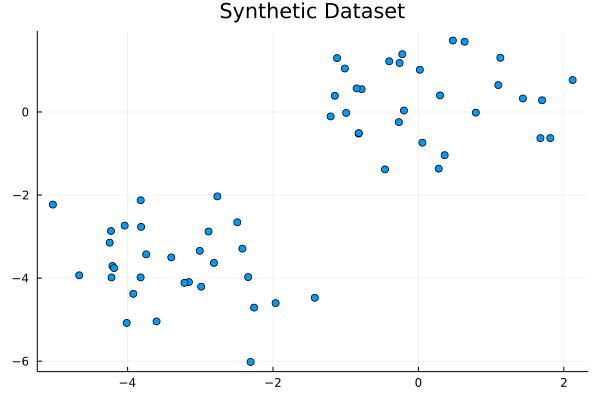

In [2]:

# Construct 30 data points for each cluster.
N = 30

# Parameters for each cluster, we assume that each cluster is Gaussian distributed in the example.
μs = [-3.5, 0.0]

# Construct the data points.
x = mapreduce(c -> rand(MvNormal([μs[c], μs[c]], 1.), N), hcat, 1:2)

# Visualization.
scatter(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

### the Gaussian Mixture Model

The idea is well known in Bayesian modelling. In particular we will assume that there are $K$ clusters with each cluster modelled by a Gaussian distribution. For simplicity we will assume that the variance is 1 and thus we will only include the locations, $\mu_k$ for $1 \leq k \leq K$, of each Gaussian in the unknown parameters. We will assume that the locations are each sampled from a standard normal distribution:

$$ \mu_k \sim Normal(0,1) \ \forall \ k.$$

We will also assume that the Gaussian distributions smoothly mix using a mixing weight. We can use a Dirichlet, with parameter $\alpha$, to model the mixing weights which must sum to 1 (ie they form a simplex). The mixing weights are a vector in $\mathbb{R}^K$:

$$ w \sim Dirichlet(K, \alpha).$$

Then for each datapoint $x_i$, $1 \leq i \leq N$, we will sample a categorical assignment variable, $z_i \in \{1, ..., K\}$, which indexes which cluster the $i^{th}$ sample belongs:

$$ z_i \sim Categorical(w) \ \forall \ i,$$
$$ x_i \sim Normal(\mu_{z_i}, 1) \ \forall \ i.$$

### Using Turing

In [3]:
using Turing, MCMCChains

# Turn off the progress monitor.
Turing.setprogress!(false);

┌ Info: [Turing]: progress logging is disabled globally
└ @ Turing /home/josinai/.julia/packages/Turing/YGtAo/src/Turing.jl:22
┌ Info: [AdvancedVI]: global PROGRESS is set as false
└ @ AdvancedVI /home/josinai/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:15


In [4]:
@model GaussianMixtureModel(x) = begin
    
    D, N = size(x)

    # Draw the parameters for cluster 1.
    μ1 ~ Normal(0,1)
    
    # Draw the parameters for cluster 2.
    μ2 ~ Normal(0,1)
    
    μ = [μ1, μ2]
    
    # Draw the weights for the K clusters from a Dirichlet distribution.
    
    α = 1.0
    w ~ Dirichlet(2, α)
    
    # Draw assignments for each datum and generate it from a multivariate normal.
    k = Vector{Int}(undef, N)
    for i in 1:N
        k[i] ~ Categorical(w)
        x[:,i] ~ MvNormal([μ[k[i]], μ[k[i]]], 1.)
    end
    return k
end

GaussianMixtureModel (generic function with 1 method)

Now using the synthetic data, let's instantiate the model function:

In [5]:
gmm_model = GaussianMixtureModel(x);

And now let's a Gibbs sampler to efficiently sample the categorical assignments, and a Hamiltonian Monte Carlo sampler to efficiently sample the cluster locations:

In [6]:
gmm_sampler = Gibbs(PG(100, :k), HMC(0.05, 10, :μ1, :μ2))
tchain = sample(gmm_model, gmm_sampler, MCMCThreads(), 100, 3);

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /home/josinai/.julia/packages/AbstractMCMC/BPJCW/src/sample.jl:291


We have asked `MCMCChains` to sample 3 chains for testing purposes. We can visualise these three chains and check that they all independently converge to the same posterior belief of the unknown parameters $\mu_1$, $\mu_2$:

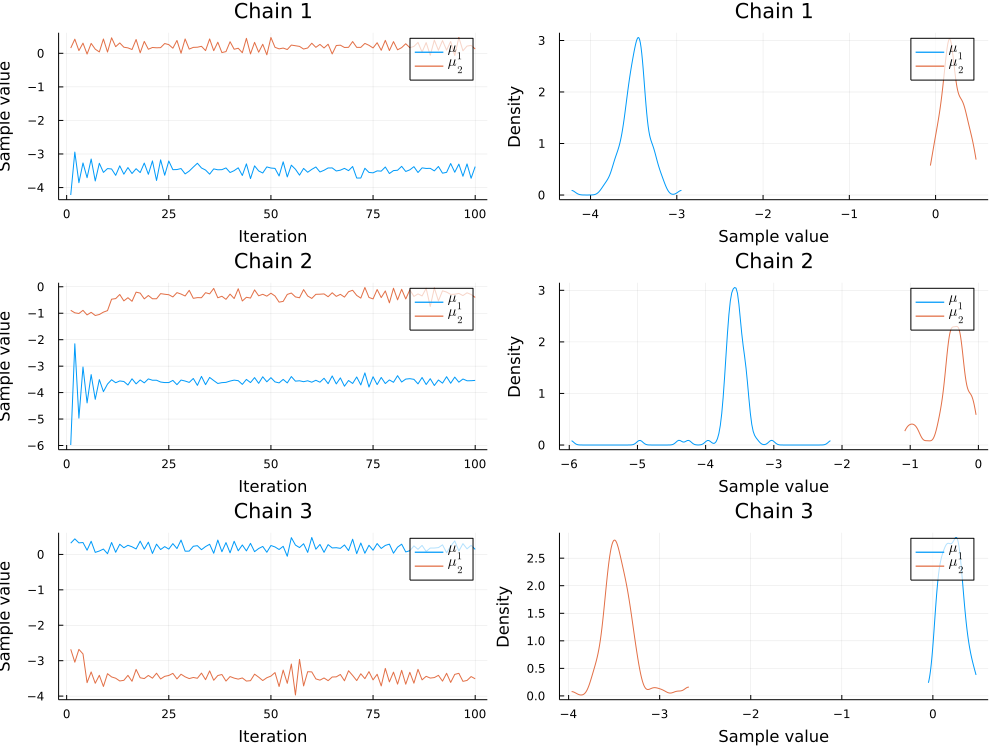

In [23]:
# ids = findall(map(name -> occursin("μ", string(name)), names(tchain)));
p=plot(tchain[:, ids, :], legend=true, labels = ["\$\\mu_1\$" "\$\\mu_2\$"], colordim=:parameter, legendfontsize=10, background_color_legend = RGBA(1,1,1,0.7))


> You'll note here that it appears the location means are switching between chains. We will address this in future tutorials. For those who are keenly interested, see this article on potential solutions.

### Predictive Plot

We can use a contour plot to visualise the correctness of the posterior distribution on each parameter. To do so we need to define a posterior predictive function which will use the converged chain samples on $\mu_1$ and $\mu_2$. For now we will just use the first chain for validation.

In [24]:
tchain = tchain[:, :, 1];

In [26]:
function predict(x, y, w, μ)
    # Use log-sum-exp trick for numeric stability.
    # Recall `+` in the log domain is `*`` in the exp domain
    return Turing.logaddexp(
        log(w[1]) + logpdf(MvNormal([μ[1], μ[1]], 1.), [x, y]), 
        log(w[2]) + logpdf(MvNormal([μ[2], μ[2]], 1.), [x, y])
    )
end

predict (generic function with 1 method)

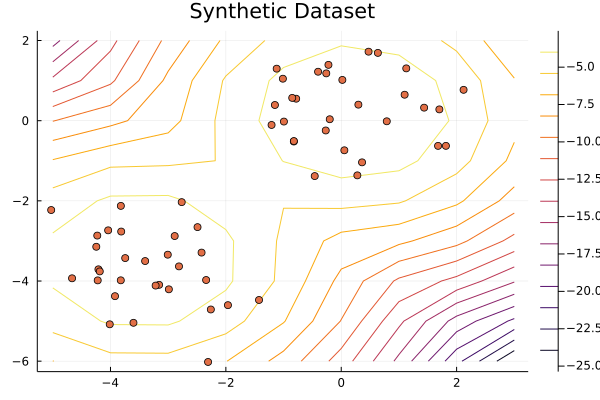

In [27]:
contour(range(-5, stop = 3), range(-6, stop = 2), 
    (x, y) -> predict(x, y, [0.5, 0.5], [mean(tchain[:μ1]), mean(tchain[:μ2])])
)
scatter!(x[1,:], x[2,:], legend = false, title = "Synthetic Dataset")

### Inferred Assignments

Now let's see how we can use the Gaussian mixture model to assign the data to each cluster: ie _unsupervised classification_:

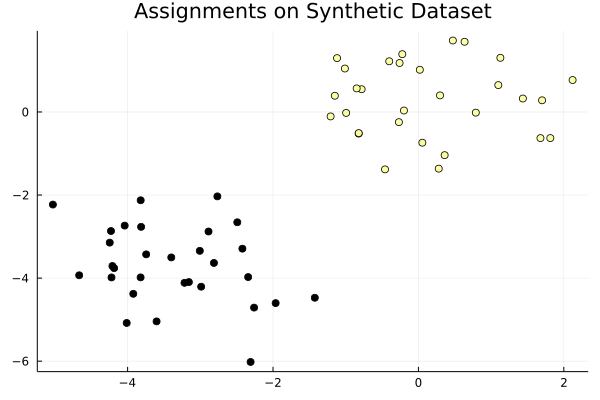

In [28]:
assignments = mean(MCMCChains.group(tchain, :k)).nt.mean
scatter(x[1,:], x[2,:], 
    legend = false, 
    title = "Assignments on Synthetic Dataset", 
    zcolor = assignments)